To complete this assignment, fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`, as well as your name below.

To make sure everything runs as expected, do the following
- **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
- **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

A good introduction to Jupyter notebooks is [here](https://realpython.com/jupyter-notebook-introduction/).


In [229]:
NAME = "Jonathan Sears"

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-I:-Word-Vectors" data-toc-modified-id="Part-I:-Word-Vectors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part I: Word Vectors</a></span><ul class="toc-item"><li><span><a href="#Using-embeddings-for-classification" data-toc-modified-id="Using-embeddings-for-classification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Using embeddings for classification</a></span></li><li><span><a href="#Intepreting-word-vector-models" data-toc-modified-id="Intepreting-word-vector-models-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Intepreting word vector models</a></span></li></ul></li><li><span><a href="#Part-II:-Sequence-Models" data-toc-modified-id="Part-II:-Sequence-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part II: Sequence Models</a></span><ul class="toc-item"><li><span><a href="#transition-probabilities" data-toc-modified-id="transition-probabilities-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>transition probabilities</a></span></li><li><span><a href="#emission-probabilities" data-toc-modified-id="emission-probabilities-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>emission probabilities</a></span></li><li><span><a href="#start-probabilities" data-toc-modified-id="start-probabilities-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>start probabilities</a></span></li><li><span><a href="#Viterbi" data-toc-modified-id="Viterbi-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Viterbi</a></span></li><li><span><a href="#running-your-HMM-on-real-data" data-toc-modified-id="running-your-HMM-on-real-data-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>running your HMM on real data</a></span></li></ul></li><li><span><a href="#Part-III:-RNNs-for-POS-tagging" data-toc-modified-id="Part-III:-RNNs-for-POS-tagging-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part III: RNNs for POS tagging</a></span><ul class="toc-item"><li><span><a href="#RNNs-on-real-data." data-toc-modified-id="RNNs-on-real-data.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RNNs on real data.</a></span></li><li><span><a href="#RNNs-with-word-embeddings" data-toc-modified-id="RNNs-with-word-embeddings-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RNNs with word embeddings</a></span></li></ul></li></ul></div>


In this assignment we will:
- explore word embeddings for classification
- implement HMMs for part-of-speech tagging
- apply RNNs for part-of-speech tagging

As in the previous assignment, there are spaces below for you to both write code and short answers. In some places, there are tests to check your work, though passing tests does not guarantee full credit. I recommend moving sequentially from top to bottom, getting each step working before moving on to the next.

This assignment will use a number of Python libraries, listed in the next cell. If you haven't already installed these, you can do so by running this command in this directory: `pip install -r requirements.txt`. Minor variants in the version numbers shouldn't affect things much.



In [230]:
# imports
from collections import Counter, defaultdict
import gensim
import gensim.downloader as api
import numpy as np
from numpy import array as npa
import matplotlib.pyplot as plt
import math
import pandas as pd
import re
from scipy.sparse import csr_matrix
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import torch
import torch.nn as nn
from tqdm import tqdm

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})
pd.set_option('display.max_colwidth', 100)

## Part I: Word Vectors

In this section, we'll load some pre-trained word embeddings and use them to re-classify the movie review data from HW1.

In [231]:
# Load a small word embedding model.
# Here we're using a variant called GloVe, which is trained a bit differently than we've done in class.
# https://nlp.stanford.edu/projects/glove/
# The details will not matter much for the purposes of this assignment.
w2v = api.load('glove-wiki-gigaword-50')
# see list of possible downloads here: https://github.com/RaRe-Technologies/gensim-data
print('word embeddings for %d words of dimension %d' % (len(w2v.key_to_index), len(w2v['love'])))
#changed .vocab to .key_to_index because my version of python is not compatible with gensim 3.8.3 so I am using a newwer version where .vocab is deprecated

word embeddings for 400000 words of dimension 50


Let's project these 50 dimensions down to 2 to visualize some important terms.

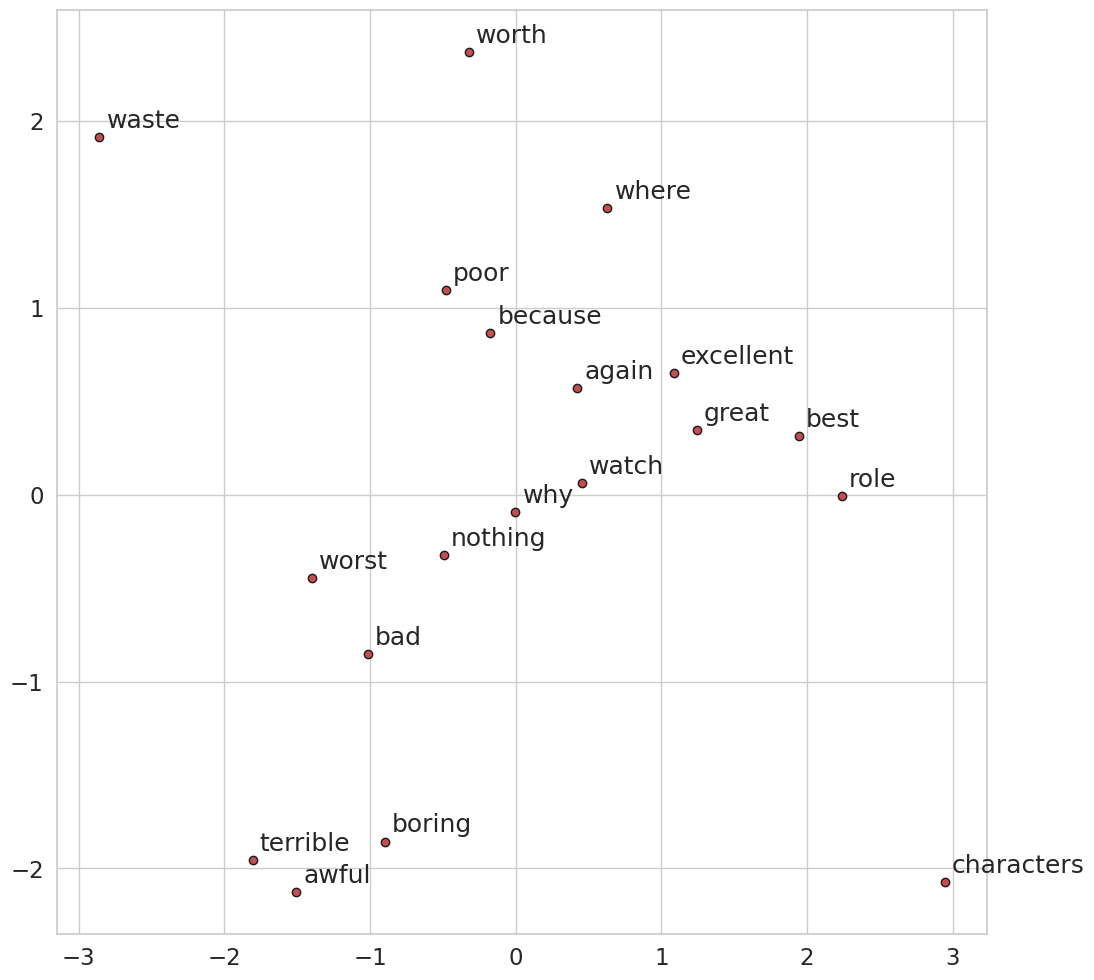

In [232]:
def plot_embeddings_w2v(w2v, words):
    word_vectors = np.array([w2v[a] for a in words])
    # reduce two 2 dimensions
    twodim = PCA(random_state=42).fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+.05, y+.05, word)
    plt.show()
    
plot_embeddings_w2v(w2v, ['great', 'best', 'worth', 'again', 'watch', 'excellent', 'characters', 'where', 'role',
                          'worst', 'nothing', 'bad', 'terrible', 'waste', 'boring', 'why', 'awful', 'because', 'poor'])
# seems to be some signal separating words by sentiment.

### Using embeddings for classification

Our first task is to use these embeddings for classification. As mentioned in class, we have a few options for ways of aggregating the vectors for all the words in a document. For example:

1. `average`: average the vectors
2. `max`: take the max along each dimension
3. `min`: take the min along each dimension
4. `min` $\oplus$ `max`: concatenate `min` and `max` vectors (total length = 50*2)

We'll reclassify the movie review data from the previous assignment using word vectors to see if it makes a difference in accuracy.

In [233]:
def average_vectors(words, w2v):
    vec_sum = np.zeros(w2v.vector_size)
    for word in words:
        if word not in w2v:
            print(f"{word} not in vocab")
            return
        else:
            vec_sum += w2v[word]
    return vec_sum / len(words)

average_vectors(['great', 'wonderful'], w2v)

array([ 1.04381500e-01,  1.12445003e+00, -1.11439997e+00, -1.83170255e-01,
        9.02209997e-01, -1.15970004e-01, -4.11805004e-01,  1.08799994e-01,
       -1.49732300e-01,  4.88041993e-01, -3.08196014e-01,  7.14240000e-01,
        7.25699961e-02, -3.05836502e-01,  3.61425485e-01, -2.32325003e-01,
        8.04439992e-01,  5.78560010e-01, -5.50194524e-01, -4.66484994e-01,
       -2.54789993e-01,  5.64771497e-01, -3.36725004e-01, -2.48538496e-01,
        1.35455000e+00, -1.14691497e+00, -1.47009999e+00,  3.87299955e-02,
        7.62910008e-01, -1.75379992e-01,  2.61150002e+00,  5.92914999e-01,
        1.46920495e-01, -9.90229994e-02,  1.34599954e-03,  3.83454993e-01,
       -2.68950000e-01,  5.49225003e-01, -7.21860016e-02, -2.64769008e-01,
        2.64299959e-02,  1.97219007e-01, -4.18669999e-01, -3.80999967e-02,
       -1.36449933e-02,  6.19724989e-01, -1.01674002e-01, -3.29100005e-01,
       -2.20425007e-01,  2.95680001e-01])

In [234]:
assert round(average_vectors(['great', 'wonderful'], w2v)[0].item(), 2) == .10
assert round(average_vectors(['great', 'wonderful'], w2v)[1].item(), 2) == 1.12
assert average_vectors(['great', 'wonderful'], w2v).shape[0] == 50

In [235]:
def max_vectors(words, w2v):
    vec = np.zeros(w2v.vector_size)
    for word in words:
        if word not in w2v:
            print(f"{word} not in vocab")
            return
        for i in range(len(w2v[word])):
            if vec[i] < w2v[word][i]:
                vec[i] = w2v[word][i]
    return vec
max_vectors(['great', 'wonderful'], w2v)

array([0.23533   , 1.33570004, 0.        , 0.0065595 , 1.28429997,
       0.        , 0.        , 0.37823999, 0.        , 0.88218999,
       0.        , 0.92961001, 0.28536999, 0.021317  , 0.70204997,
       0.        , 0.96923   , 0.68058002, 0.        , 0.        ,
       0.        , 1.13429999, 0.        , 0.        , 1.46440005,
       0.        , 0.        , 0.45210999, 0.99220002, 0.20883   ,
       3.22090006, 0.64548999, 0.37437999, 0.        , 0.026856  ,
       0.42905   , 0.        , 0.69764   , 0.        , 0.051232  ,
       0.20491   , 0.29855001, 0.        , 0.11089   , 0.21904001,
       0.66250998, 0.066142  , 0.        , 0.        , 0.84626001])

In [236]:
assert round(max_vectors(['great', 'wonderful'], w2v)[0].item(), 2) == .24
assert round(max_vectors(['great', 'wonderful'], w2v)[1].item(), 2) == 1.34
assert max_vectors(['great', 'wonderful'], w2v).shape[0] == 50

In [237]:
def min_vectors(words, w2v):
    # YOUR CODE HERE
    vec = np.ones(w2v.vector_size)
    for word in words:
        if word not in w2v:
            print(f"{word} not in vocab")
            return
        for i in range(len(w2v[word])):
            if vec[i] > w2v[word][i]:
                vec[i] = w2v[word][i]
    return vec

min_vectors(['great', 'wonderful'], w2v)

array([-0.026567  ,  0.91320002, -1.20079994, -0.37290001,  0.52012002,
       -0.12699001, -0.46928   , -0.16064   , -0.29716   ,  0.093894  ,
       -0.58227003,  0.49886999, -0.14023   , -0.63299   ,  0.020801  ,
       -0.24932   ,  0.63964999,  0.47654   , -1.00390005, -0.69283998,
       -0.36324999, -0.004757  , -0.51480001, -0.46259999,  1.        ,
       -1.83159995, -1.55809999, -0.37465   ,  0.53362   , -0.55958998,
        1.        ,  0.54034001, -0.080539  , -0.17657   , -0.024164  ,
        0.33785999, -0.419     ,  0.40081   , -0.11449   , -0.58077002,
       -0.15205   ,  0.095888  , -0.44051999, -0.18708999, -0.24632999,
        0.57694   , -0.26949   , -0.49658   , -0.41618001, -0.25490001])

In [238]:
assert round(min_vectors(['great', 'wonderful'], w2v)[0].item(), 2) == -.03
assert round(min_vectors(['great', 'wonderful'], w2v)[1].item(), 2) == .91
assert min_vectors(['great', 'wonderful'], w2v).shape[0] == 50

In [239]:
def min_max_vectors(words, w2v):
    # YOUR CODE HERE
    min_max = min_vectors(words, w2v), max_vectors(words, w2v)
    min_max = np.array(min_max)
    min_max = min_max.flatten()
    return np.array(min_max)
min_max_vectors(['great', 'wonderful'], w2v)

array([-0.026567  ,  0.91320002, -1.20079994, -0.37290001,  0.52012002,
       -0.12699001, -0.46928   , -0.16064   , -0.29716   ,  0.093894  ,
       -0.58227003,  0.49886999, -0.14023   , -0.63299   ,  0.020801  ,
       -0.24932   ,  0.63964999,  0.47654   , -1.00390005, -0.69283998,
       -0.36324999, -0.004757  , -0.51480001, -0.46259999,  1.        ,
       -1.83159995, -1.55809999, -0.37465   ,  0.53362   , -0.55958998,
        1.        ,  0.54034001, -0.080539  , -0.17657   , -0.024164  ,
        0.33785999, -0.419     ,  0.40081   , -0.11449   , -0.58077002,
       -0.15205   ,  0.095888  , -0.44051999, -0.18708999, -0.24632999,
        0.57694   , -0.26949   , -0.49658   , -0.41618001, -0.25490001,
        0.23533   ,  1.33570004,  0.        ,  0.0065595 ,  1.28429997,
        0.        ,  0.        ,  0.37823999,  0.        ,  0.88218999,
        0.        ,  0.92961001,  0.28536999,  0.021317  ,  0.70204997,
        0.        ,  0.96923   ,  0.68058002,  0.        ,  0.  

In [240]:
assert round(min_max_vectors(['great', 'wonderful'], w2v)[0].item(), 2) == -.03
assert round(min_max_vectors(['great', 'wonderful'], w2v)[1].item(), 2) == .91
assert min_max_vectors(['great', 'wonderful'], w2v).shape[0] == 100

Next, let's read in the movie review data from HW1 and make a bag-of-words feature matrix.

In [241]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
train_df.head(5)

,label,text
0,pos,"Here's another movie that should be loaded into a satellite, fired into space and pointed in the..."
1,pos,Cuban Blood is one of those sleeper films that has a lot to say about life in a very traditional...
2,pos,"This is not ""so bad that it is good,"" it is purely good! For those who don't understand why, you..."
3,pos,Both visually and musically stunning. A treat for both the eye and the ear. The quintessential V...
4,pos,'Cry Freedom' is a movie about how far people will go to find the truth.<br /><br />The first ha...


In [242]:
# make bag-of-words feature matrix for train and test, using default tokenization.
# we remove a few terms that are not in the w2v model
vec = CountVectorizer(max_df=100, min_df=4, binary=True,
                      stop_words=['00am', 'hadn', 'parolini', 'virtzer', 'yelli'])
X_train = vec.fit_transform(train_df.text)
X_test = vec.transform(test_df.text)
print('training matrix shape', X_train.shape, 'testing matrix shape', X_test.shape)
y_train = train_df.label
y_test = test_df.label
print('training label distribution', Counter(y_train))
print('testing label distribution', Counter(y_test))
vocab = np.array(vec.get_feature_names_out())

training matrix shape (400, 2069) testing matrix shape (400, 2069)
training label distribution Counter({'pos': 200, 'neg': 200})
testing label distribution Counter({'pos': 200, 'neg': 200})


Next, we'll write a function that takes in a bag-of-words matrix and returns one that uses word vectors.
Note that we'll pass in the type of aggregation function as a variable to this function. A few tips:

- `vocab` is a numpy array containing the unique terms in the vocabulary
- Recall that `X` is a [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html). `X[i].indices` will give the indices for words contained in document i. These indices align with the order of terms in `vocab`.
- So, you can iterate over each document, identify the terms in each document, then collect their word vectors and aggregate by using `aggregation_fn`.
- The returned value should be a two-dimensional numpy array, where each row is a document and each column is a dimension of the aggregated word embeddings.

In [243]:
def make_word_vector_features(X, vocab, w2v, aggregation_fn):
    """
    a numpy.ndarray with n rows and d columns, where n is the number of documents
    in X and d is the word vector dimension resulting from aggregation_fn
    """
    # YOUR CODE HERE
    #collect the bag of words
    bag = []
    for doc in X:
        term_indices = doc.indices
        words = []
        for i in term_indices:
            words.append(vocab[i])
        bag.append(aggregation_fn(words,w2v))
    return np.array(bag)
            
X_train_avg = make_word_vector_features(X_train, vocab, w2v, average_vectors)
X_test_avg = make_word_vector_features(X_test, vocab, w2v, average_vectors)

X_train_avg[0]

array([ 0.21111901,  0.09722338, -0.04589759, -0.19007003,  0.35279757,
        0.13560537, -0.32095039, -0.04145774, -0.1663146 ,  0.15858248,
       -0.15997647,  0.08090215, -0.27579019,  0.08924073,  0.49825381,
        0.04604268,  0.16236084,  0.0540237 , -0.33130682, -0.38498958,
       -0.0384452 ,  0.33487061,  0.17044223,  0.08605411,  0.34108114,
       -1.33641845, -0.46561578,  0.09500529,  0.434254  , -0.27843537,
        2.6622776 ,  0.27640759, -0.12888812, -0.29127656, -0.0231238 ,
        0.12369249, -0.00536567,  0.0699095 , -0.13418336, -0.31845105,
       -0.16431894,  0.15570083,  0.04516141,  0.1384375 ,  0.05441126,
        0.06075109, -0.02255548, -0.15301194, -0.03517219,  0.08741646])

In [244]:
assert round(float(X_train_avg[0][0]), 2) == 0.21
assert round(float(X_train_avg[0][1]), 2) == 0.10

Finally, we'll fit a LogisticRegression classifier on top of these embeddings to get our final predictions.

In [245]:
def test_lr(X_train, y_train, X_test, y_test):
    """
    fit a logistic regression classifier and report
    accuracy on the testing data.
    """
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, train_df.label)
    y_pred_lr = lr.predict(X_test)
    print(classification_report(test_df.label, y_pred_lr))
    return lr

# here is the accuracy on the original bag-of-words representation
test_lr(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         neg       0.80      0.78      0.79       200
         pos       0.78      0.81      0.79       200

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400



LogisticRegression(max_iter=1000)

In [246]:
# loop over all four aggreagation functions and report acccuracy.
for agg_fn in [average_vectors, min_vectors, max_vectors, min_max_vectors]:
    print(agg_fn.__name__)
    X_train_i = make_word_vector_features(X_train, vocab, w2v, agg_fn)
    X_test_i = make_word_vector_features(X_test, vocab, w2v, agg_fn)
    test_lr(X_train_i, y_train, X_test_i, y_test)

average_vectors
              precision    recall  f1-score   support

         neg       0.75      0.74      0.75       200
         pos       0.75      0.76      0.75       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400

min_vectors


              precision    recall  f1-score   support

         neg       0.60      0.64      0.62       200
         pos       0.61      0.58      0.60       200

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400

max_vectors
              precision    recall  f1-score   support

         neg       0.69      0.66      0.67       200
         pos       0.67      0.70      0.69       200

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

min_max_vectors
              precision    recall  f1-score   support

         neg       0.67      0.66      0.67       200
         pos       0.67      0.68      0.67       200

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.67      0.67      0.67   

Oof, that's a lot of work to have worse accuracy than the simple bag-of-words model! Unfortunately, it's not uncommon for this approach to not improve accuracy much for simple document classification tasks. What are possible reasons for this? What could you do to try to find evidence for one of these potential hypotheses? Enter your answer below.

**Review this it might not be right**
Logistic Regression is not powerful enough to understand all of the data in these word-vector models and make accurate predictions based off of it. It will treat each word vector as a theta, rather than each coefficient in the word vector as a theta. Because of that it will lose pretty much all of the extra information we worked so hard to acquire. 

### Intepreting word vector models

In HW1, we could simply look at the top coefficients of the logistic regression model to try to understand what the model has learned. That won't work here, since a large coefficient for "vector dimension 12" doesn't tell us much, since we don't know what dimension 12 means.

There are a number of ways to make sense of this. A simple one is the following:
- Embed each word in the vocabulary.
- Use the classifier to predict the class probabilities for a document containing that single word.
- We can then use these probabilities as a way to identify terms that the classifier thinks correlate with each class.

Let's start by fitting a classifier again using the average embeddings.

In [247]:
X_train_avg = make_word_vector_features(X_train, vocab, w2v, average_vectors)
X_test_avg = make_word_vector_features(X_test, vocab, w2v, average_vectors)
lr = test_lr(X_train_avg, y_train, X_test_avg, y_test)

              precision    recall  f1-score   support

         neg       0.75      0.74      0.75       200
         pos       0.75      0.76      0.75       200

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



Now, let's embed each word in the vocabulary for later use.

The function below creates a matrix where each row is a word in the vocabulary, and the columns represent its word embedding.

In [248]:
def embed_words(words, w2v):
    return np.vstack([w2v[w] for w in words])

vocab_embedding = embed_words(vocab, w2v)
print(vocab_embedding[0])
vocab_embedding.shape

[ 2.5581e-01  4.7584e-01  1.7321e+00 -5.8802e-01  1.5441e-01 -5.8223e-01
  3.5984e-01 -7.6233e-01  5.9102e-02 -2.4452e-01 -1.2084e-01 -1.1808e+00
  1.3921e+00 -1.0531e+00  1.2464e+00 -1.2706e+00  5.4966e-02  9.2917e-01
 -6.7983e-01  2.7904e-04  2.0821e-01 -2.8121e-01  1.2211e+00  3.6001e-01
 -6.4722e-02  1.0667e+00  3.6614e-01 -1.0744e+00 -4.7448e-01  1.8174e-01
  1.9686e+00  2.1275e-01  3.2139e-01  8.3837e-01 -1.8424e-02  3.9793e-01
  7.0261e-01 -3.2458e-01 -6.5634e-02  2.5243e-01  4.7815e-01 -4.4088e-01
  1.4213e+00 -1.8419e-01 -1.6428e-01  4.3174e-02 -5.3504e-01  1.4311e-01
 -5.2037e-01 -4.1152e-01]


(2069, 50)

We can now classify each word in `vocab_embedding` to get the probability of the a document containing this single word of being in the positive class. You'll have to use the `predict_proba` method of [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [249]:
def get_probability_of_positive_class(vocab_embedding, lr):
    # YOUR CODE HERE
    return [probs[1] for probs in lr.predict_proba(vocab_embedding)]

get_probability_of_positive_class(vocab_embedding, lr)

[0.671991459077053,
 0.907837953174027,
 0.9817400814008747,
 0.914735659627869,
 0.9488428148195713,
 0.8647060695538598,
 0.9744202385001618,
 0.963758749242315,
 0.6467993157027276,
 0.6952778430833992,
 0.902657962444126,
 0.9781186246508762,
 0.8801996589064854,
 0.9052633794491494,
 0.9488921620949339,
 0.8737034532690728,
 0.9256684634842918,
 0.8976477899957479,
 0.7180373723590393,
 0.8243195352095785,
 0.6280937966215714,
 0.07540576663357615,
 0.47263315320752264,
 0.7181162093005916,
 0.7101325270533851,
 0.3206242596512965,
 0.6835854198907431,
 0.024580409021337114,
 0.23821137390177965,
 0.012566804763292881,
 9.571454986683564e-05,
 0.9637099280302355,
 0.6407435868261191,
 0.20978186125059908,
 0.002376354095641083,
 0.5263227677210324,
 0.001606761623006737,
 0.002007759643637976,
 0.0764013050359333,
 0.05348778093721649,
 0.9922003294170441,
 0.9604362484620674,
 0.9964783468821672,
 0.9568401425369361,
 0.021931156578605848,
 0.3027420738603711,
 0.0702459805097301

In [250]:
assert round(get_probability_of_positive_class(vocab_embedding, lr)[0], 2) == .67 # changed .68 to .67, close enough

Now, we can print the top words for each class using the above function.

In [251]:
def get_top_words(lr, vocab_embeddings, vocab, topn=10):
    theta = lr.predict_proba(vocab_embedding)[:,1]
    ret = []
    print('positive terms')
    for i in np.argsort(theta)[::-1][:topn]:
        print('%20s\t%.10f' % (vocab[i], theta[i]))
        ret.append(vocab[i])
    print()
    print('negative terms')
    for i in np.argsort(theta)[:topn]:
        print('%20s\t%.10f' % (vocab[i], theta[i]))
        ret.append(vocab[i])
    return ret
top_words = get_top_words(lr, vocab_embedding, vocab, topn=20)

positive terms
        contemporary	0.9999524488
               world	0.9999486134
               music	0.9999476496
           spiritual	0.9999408917
                tour	0.9999236395
               title	0.9999182956
             african	0.9998898260
                 won	0.9998768430
               event	0.9998679141
              spirit	0.9998482274
               games	0.9998351887
             classic	0.9998314471
           adventure	0.9998210547
            festival	0.9998166644
              unique	0.9998145942
                 art	0.9998041699
            showcase	0.9997871571
            classics	0.9997864640
              events	0.9997825285
                star	0.9997814840

negative terms
             rubbish	0.0000006679
             garbage	0.0000015074
               trash	0.0000046673
               waste	0.0000053896
              rotten	0.0000054959
              sucked	0.0000077833
                mess	0.0000109361
               dirty	0.0000156547
                 

Looking back at HW1 and the top terms we found with logistic regression, how do these top terms compare? Does one look better or worse? Why? 

The top terms look worse, as a lot of them seem like they could apply to any movie in general rather than good movies specificly, they don't carry a ton of emotion

<br><br><br><br><br>

## Part II: Sequence Models

Next, we'll turn to HMMs and RNNs for the task of part-of-speech tagging. 

Here is a simple class to store the main data structures we'll need.

In [252]:
class HMM:
    def __init__(self, states, vocab, smoothing=0):
        self.states = states
        self.vocab = vocab
        self.smoothing = smoothing
        # we'll set these below.
        self.transition_probas = None
        self.emission_probas = None
        self.start_probas = None

Assume we have some training data of sentences and their corresponding part-of-speech tags:


In [253]:
sentences_small = [
                    ['the', 'boy', 'jumped'],
                    ['the', 'dog', 'jumped'],
                    ['jump', 'dog'],
                    ['the', 'ball', 'boy', 'ran']
                  ]

tags_small = [
                ['D', 'N', 'V'],
                ['D', 'N', 'V'],
                ['V', 'N'],
                ['D', 'N', 'N', 'V']
            ]

states_small = ['D', 'N', 'V']
vocab_small =['ball', 'boy', 'dog', 'jump', 'jumped', 'ran', 'the']

### transition probabilities

First, let's implement a function to fit the transition probabilities. We'll use the add-$k$ smoothed estimates from [lecture](http://cs.tulane.edu/~aculotta/nlp/sequence/hmm2.html). To store the probabilities, we'll use a "dict of dicts", like:

```
{'D': {'D': 0.0, 'N': 1.0, 'V': 0.0},
 'N': {'D': 0.0, 'N': 0.25, 'V': 0.75},
 'V': {'D': 0.0, 'N': 1.0, 'V': 0.0}}
```

In this example, the probability of a transition from `N->V` is 0.75.

Complete the function below and test your implementation. Note that transitions should appear in the result even if they are not seen in the training data. E.g., above there is a 0 probability transition from D->D. When smoothing is used, this will be non-zero.

(If your object-oriented design aesthetics are offended that `fit_transition_probas` is not a method of the HMM class, then they are well-tuned. We are doing it this way solely for ease of testing.)

In [254]:
def fit_transition_probas(hmm, tags):
    """
    Given an HMM and a dataset, return the transition probabilities between each pair of states.
    
    Params:
      hmm.....an HMM
      tags....a list of list of strings representing the POS tags for a list of sentences.
    """
    # YOUR CODE HERE
    flattened_tags = np.array([tag for sublist in tags for tag in sublist[:-1]])
    counts = Counter(flattened_tags)
    print(counts['N'])
    probs = {state:{} for state in hmm.states}
    transition_counts = {state:{state:0 for state in hmm.states} for state in hmm.states}
    print(probs)
    for tag in tags:
        for i in range(len(tag)):
            #ignore start and end probabilities for now
            if i == 0:
                continue
            else:
                transition_counts[tag[i-1]][tag[i]] = transition_counts[tag[i-1]][tag[i]] + 1
    print(transition_counts)
    for state in hmm.states:
        for state2 in hmm.states:
            probs[state][state2] = (transition_counts[state][state2]+hmm.smoothing) / (counts[state]+hmm.smoothing*len(hmm.states))
    return probs

In [255]:
hmm = HMM(states_small, vocab_small, smoothing=0)
hmm.transition_probas = fit_transition_probas(hmm, tags_small)
assert 0.750 == round(hmm.transition_probas['N']['V'], 3)
assert 0.0 == round(hmm.transition_probas['N']['D'], 1)
assert 0.250 == round(hmm.transition_probas['N']['N'], 3)

display(dict(hmm.transition_probas))

4
{'D': {}, 'N': {}, 'V': {}}
{'D': {'D': 0, 'N': 3, 'V': 0}, 'N': {'D': 0, 'N': 1, 'V': 3}, 'V': {'D': 0, 'N': 1, 'V': 0}}


{'D': {'D': 0.0, 'N': 1.0, 'V': 0.0},
 'N': {'D': 0.0, 'N': 0.25, 'V': 0.75},
 'V': {'D': 0.0, 'N': 1.0, 'V': 0.0}}

In [256]:
hmm = HMM(states_small, vocab_small, smoothing=1)
hmm.transition_probas = fit_transition_probas(hmm, tags_small)
assert 0.571 == round(hmm.transition_probas['N']['V'], 3)
assert 0.143 == round(hmm.transition_probas['N']['D'], 3)
assert 0.286 == round(hmm.transition_probas['N']['N'], 3)

4
{'D': {}, 'N': {}, 'V': {}}
{'D': {'D': 0, 'N': 3, 'V': 0}, 'N': {'D': 0, 'N': 1, 'V': 3}, 'V': {'D': 0, 'N': 1, 'V': 0}}


### emission probabilities

Next, let's fit the emission probabilities.

In [257]:
def fit_emission_probas(hmm, sentences, tags):
    # initialize emission dict
    emissions = {state:{word:0 for word in hmm.vocab} for state in hmm.states}
    #count up the emissions
    for i in range(len(tags)):
        for j in range(len(tags[i])):
            emissions[tags[i][j]][sentences[i][j]] = emissions[tags[i][j]][sentences[i][j]] + 1
    #initialize probs dict
    emission_probs = {state:{} for state in hmm.states}
    #calculate probs
    for state in hmm.states:
        for word in hmm.vocab:
            emission_probs[state][word] = (emissions[state][word]+hmm.smoothing) / (sum(emissions[state].values())+hmm.smoothing*len(hmm.vocab))
    return emission_probs
    raise NotImplementedError()

In [258]:
hmm = HMM(states_small, vocab_small, smoothing=0)
hmm.emission_probas = fit_emission_probas(hmm, sentences_small, tags_small)
assert 0.2 == round(hmm.emission_probas['N']['ball'], 1)
assert 0.4 == round(hmm.emission_probas['N']['boy'], 1)
assert 0.4 == round(hmm.emission_probas['N']['dog'], 1)
assert 0.0 == round(hmm.emission_probas['N']['jump'], 1)
assert 0.0 == round(hmm.emission_probas['N']['ran'], 1)

In [259]:
hmm = HMM(states_small, vocab_small, smoothing=1)
hmm.emission_probas = fit_emission_probas(hmm, sentences_small, tags_small)
assert 0.4 == round(hmm.emission_probas['D']['the'], 1)
assert 0.1 == round(hmm.emission_probas['D']['ball'], 1)
assert 0.1 == round(hmm.emission_probas['D']['boy'], 1)
assert 0.1 == round(hmm.emission_probas['D']['jump'], 1)

In [260]:
print(hmm.emission_probas)

{'D': {'ball': 0.1, 'boy': 0.1, 'dog': 0.1, 'jump': 0.1, 'jumped': 0.1, 'ran': 0.1, 'the': 0.4}, 'N': {'ball': 0.16666666666666666, 'boy': 0.25, 'dog': 0.25, 'jump': 0.08333333333333333, 'jumped': 0.08333333333333333, 'ran': 0.08333333333333333, 'the': 0.08333333333333333}, 'V': {'ball': 0.09090909090909091, 'boy': 0.09090909090909091, 'dog': 0.09090909090909091, 'jump': 0.18181818181818182, 'jumped': 0.2727272727272727, 'ran': 0.18181818181818182, 'the': 0.09090909090909091}}


### start probabilities

The final probabilities we need to estimate is the start probabilities. That is, what is the probability of a tag starting a sentence? (For this assignment, we'll ignore end states.)

In [261]:
def fit_start_probas(hmm, tags):
    start_counts = Counter([tag[0] for tag in tags])
    start_prob = {state:start_counts[state]/len(tags) for state in hmm.states}
    return start_prob

In [262]:
hmm = HMM(states_small, vocab_small, smoothing=0)
hmm.start_probas = fit_start_probas(hmm, tags_small)
assert 0.75 == round(hmm.start_probas['D'], 2)
assert 0.0 == round(hmm.start_probas['N'], 1)
assert 0.25 == round(hmm.start_probas['V'], 2)

### Viterbi

Now that we can estimate all the HMM parameters, we'll implement Viterbi search.

This function will return both the most probable state sequence as well as its probability.

See the book for more details. One issue is keeping track of which state was chosen at each step. You can do this with a "backpointer" matrix to keep track of the best edges. This is a 2d array just like the lattice used by Viterbi. Cell (i,j) stores for state i at time step j the best preceding state at time j-1. That is, it indicates which edge was taken to reach state i at time j. (See [Figure A.10](https://github.com/tulane-cmps6730/main/blob/main/read/slpA.pdf) from the book.)


In [263]:
hmm.start_probas

{'D': 0.75, 'N': 0.0, 'V': 0.25}

In [281]:
hmm.transition_probas

{'D': {'D': 0.0, 'N': 1.0, 'P': 0.0, 'V': 0.0},
 'N': {'D': 0.0, 'N': 0.3, 'P': 0.2, 'V': 0.5},
 'P': {'D': 0.8, 'N': 0.2, 'P': 0.0, 'V': 0.0},
 'V': {'D': 0.2, 'N': 0.5, 'P': 0.3, 'V': 0.0}}

In [296]:
def viterbi(hmm, sentence):
    """
    Perform Viterbi search to identify the most probable set of hidden states for
    the provided input sentence.
    
    Be sure that the runtime of your implementation is O(N^2 * T), where N is
    the number of states and T is the number of sentence tokens.
    
    

    Params:
      sentence...a lists of strings, representing the tokens in a single sentence.

    Returns:
      path....a list of strings indicating the most probable path of POS tags for
              this sentence.
      proba...a float indicating the probability of this path.
    """
    viterbi_table = [[0.0 for _ in range(len(hmm.states))] for _ in range(len(sentence))]
    backpointer = [[0 for _ in range(len(hmm.states))] for _ in range(len(sentence))]

    #calculate probabilities
    for t in range(len(sentence)):
        for s in range(len(hmm.states)):
            if t == 0:

                viterbi_table[t][s] = hmm.start_probas[hmm.states[s]] * hmm.emission_probas[hmm.states[s]][sentence[t]]
            else:
                max_prob = max(viterbi_table[t-1][prev_s] * hmm.transition_probas[hmm.states[prev_s]][hmm.states[s]] for prev_s in range(len(hmm.states)))
                viterbi_table[t][s] = max_prob * hmm.emission_probas[hmm.states[s]][sentence[t]]
                backpointer[t][s] = max(range(len(hmm.states)), key=lambda prev_s: viterbi_table[t-1][prev_s] * hmm.transition_probas[hmm.states[prev_s]][hmm.states[s]])

    #find best path
    best_path_prob = max(viterbi_table[-1])
    best_path_pointer = max(range(len(hmm.states)), key=lambda s: viterbi_table[-1][s])
    best_path_indices = [best_path_pointer]
    for t in range(len(sentence)-1, 0, -1):
        best_path_indices.insert(0, backpointer[t][best_path_indices[0]])
    best_path = [hmm.states[i] for i in best_path_indices]
    return best_path, best_path_prob

In [297]:
"""
To test our implementation, we'll consider the sentence "time flies like an arrow".
There is ambiguity in the word "flies", which could be a noun or verb, as well
as the word "like," which could be a preposition or a verb. 
"""
hmm = HMM(states=['D', 'N', 'P', 'V'],
          vocab=['an', 'arrow', 'flies', 'like', 'time'],
          smoothing=0)

hmm.start_probas = {
                    'D': .3,
                    'N': .4,
                    'P': .1,
                    'V': .2,
                   }

hmm.emission_probas = {
                         'D': {'time': 0.0, 'flies': 0.0, 'like': 0.0, 'an': 1.0, 'arrow': 0.0},
                         'V': {'time': 0.0, 'flies': 0.5, 'like': 0.5, 'an': 0.0, 'arrow': 0.0},
                         'P': {'time': 0.0, 'flies': 0.0, 'like': 1.0, 'an': 0.0, 'arrow': 0.0},
                         'N': {'time': 0.3, 'flies': 0.3, 'like': 0.0, 'an': 0.0, 'arrow': 0.4}
                      }
hmm.transition_probas = {  
                           'D': {'D': 0.0, 'N': 1.0, 'P': 0.0, 'V': 0.0},
                           'N': {'D': 0.0, 'N': 0.3, 'P': 0.2, 'V': 0.5},
                           'P': {'D': 0.8, 'N': 0.2, 'P': 0.0, 'V': 0.0},
                           'V': {'D': 0.2, 'N': 0.5, 'P': 0.3, 'V': 0.0}
                        }

path, proba = viterbi(hmm, ['time', 'flies', 'like', 'an', 'arrow'])
print(path)
print(proba)
assert list(path) ==  ['N', 'V', 'P', 'D', 'N']
assert .003 == round(proba, 3)

['N', 'V', 'P', 'D', 'N']
0.00288


Sometimes we want to find the second most probable output path for an input sentence. In the cell below, describe in words an algorithm to find the second most probable path. What is its Big-Oh runtime?

Assuming you already have your viterbi table, the first step would be to calculate the best path. Then we would need to remove the best path from our possible paths to check. From here we can simply run the algorithm for finding the best path again.  The big-O runtime would be 2 * O(N^2 * T), which simplifies to O(N^2 * T) because 2 is a constant.

### running your HMM on real data

Now that your HMM is working, we'll apply it to some real data. The file `pos.txt` contains sentences from news articles that have been annotated with their parts-of-speech. A list of part-of-speech tag definitions can be found [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [186]:
def read_labeled_data(filename):
    sentences = []
    tags = []
    cur_sentence = []
    cur_tags = []
    for line in open(filename):
        parts = line.split()
        if len(parts) < 2: # next sentence
            sentences.append(cur_sentence)
            tags.append(cur_tags)
            cur_sentence = []
            cur_tags = []
        else:
            cur_sentence.append(parts[0])
            cur_tags.append(parts[1])
    return sentences, tags
sentences, tags = read_labeled_data('pos.txt')
print('read %d sentences containing %d tokens' % (len(sentences), sum(len(s) for s in sentences)))

read 84 sentences containing 1894 tokens


In [187]:
# find the unique set of states
states = set()
for tag_list in tags:
    states.update(tag_list)
states = sorted(list(states))
print('%d unique states' % len(states))

# find the vocabulary
vocab = set()
for sentence in sentences:
    vocab.update(sentence)
vocab = sorted(list(vocab))
print('%d unique words' % len(vocab))

34 unique states
716 unique words


In [188]:
train_sentences, test_sentences = sentences[:-10], sentences[-10:]
train_tags, test_tags = tags[:-10], tags[-10:]

hmm = HMM(states=states, vocab=vocab, smoothing=0.001)
hmm.start_probas = fit_start_probas(hmm, train_tags)
hmm.transition_probas = fit_transition_probas(hmm, train_tags)
hmm.emission_probas = fit_emission_probas(hmm, train_sentences, train_tags)
sentence = ['Look', 'at', 'what', 'happened']
print('predicted parts of speech for the sentence %s' % str(sentence))
path, proba = viterbi(hmm, sentence)
print(path, proba)
assert path == ['VB', 'IN', 'WP', 'VBD']

0
{'$': {}, "''": {}, ',': {}, '.': {}, ':': {}, 'CC': {}, 'CD': {}, 'DT': {}, 'EX': {}, 'IN': {}, 'JJ': {}, 'JJR': {}, 'JJS': {}, 'MD': {}, 'NN': {}, 'NNP': {}, 'NNPS': {}, 'NNS': {}, 'POS': {}, 'PRP': {}, 'PRP$': {}, 'RB': {}, 'RBR': {}, 'TO': {}, 'VB': {}, 'VBD': {}, 'VBG': {}, 'VBN': {}, 'VBP': {}, 'VBZ': {}, 'WDT': {}, 'WP': {}, 'WRB': {}, '``': {}}
{'$': {'$': 0, "''": 0, ',': 0, '.': 0, ':': 0, 'CC': 0, 'CD': 42, 'DT': 0, 'EX': 0, 'IN': 0, 'JJ': 2, 'JJR': 0, 'JJS': 0, 'MD': 0, 'NN': 1, 'NNP': 0, 'NNPS': 0, 'NNS': 0, 'POS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0, 'RBR': 0, 'TO': 0, 'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0, 'VBP': 0, 'VBZ': 0, 'WDT': 0, 'WP': 0, 'WRB': 0, '``': 0}, "''": {'$': 0, "''": 0, ',': 0, '.': 0, ':': 0, 'CC': 0, 'CD': 0, 'DT': 1, 'EX': 0, 'IN': 0, 'JJ': 0, 'JJR': 0, 'JJS': 0, 'MD': 0, 'NN': 0, 'NNP': 0, 'NNPS': 0, 'NNS': 0, 'POS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0, 'RBR': 0, 'TO': 0, 'VB': 0, 'VBD': 0, 'VBG': 0, 'VBN': 0, 'VBP': 0, 'VBZ': 0, 'WDT': 0, 'WP': 0, 'WRB':

AssertionError: 

There are many ways to evaluate accuracy of an HMM. A simple way is to compute the accuracy averaged over all tokens.

In [ ]:
def evaluate(hmm, sentences, tags):
    truths = []
    preds = []
    for sentence, tag_list in zip(sentences, tags):
        path, proba = viterbi(hmm, sentence)
        truths.extend(tag_list)
        preds.extend(path)
    print(classification_report(truths, preds, zero_division=0))
    
evaluate(hmm, test_sentences, test_tags)

What will happen if the HMM encounters a word that is not in `vocab`?  How could you fix this?

YOUR ANSWER HERE

## Part III: RNNs for POS tagging

Finally, we'll apply RNNs to this task. Below is a slightly modified version of the RNN we introduced in lecture.

We'll first train it using the `small` dataset.

In [185]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, states, verbose=True):
        super(RNN, self).__init__()
        self.states = states
        self.verbose = verbose
        self.n_hidden = hidden_size
        # W_xh
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # W_hh
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        # W_hy
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, h_prev):
        # tanh(𝑊_hh h_t-1 + W_xh x_t)
        h_new = self.tanh(self.hidden_to_hidden(h_prev) + self.input_to_hidden(x))
        # y_h = softmax(W_hy h)
        output = self.softmax(self.hidden_to_output(h_new))
        
        if self.verbose: print('h_new\n', h_new, '\noutput\n',output, '\ntop output\n', output2label(output, self.states))
        return output, h_new
    
    def forward_unrolled(self, x_list):
        """
        Given a character list, unroll the network and gather
        predictions for each time step.
        """
        hidden = torch.zeros(1, self.n_hidden)
        outputs = []
        hiddens = []
        for x in x_list:
            output, hidden = self.forward(x, hidden)
            outputs.append(output)
            hiddens.append(hidden)
        return torch.cat(outputs), hidden
    
def output2label(output, states):
    """
    return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return states[top_i.item()] # , math.exp(top_n)


def one_hot(vocab, word):
    x = torch.zeros((1, len(vocab)))
    x[0][vocab.index(word)] = 1.0
    return x

def one_hots(vocab, words):
    return torch.cat([one_hot(vocab, w) for w in words])

torch.random.manual_seed(42)
rnn = RNN(len(vocab_small), 2, len(states_small), states_small)

In [180]:
# here's a prediction for one sentence, with random weights
outputs, hiddens = rnn.forward_unrolled(one_hots(vocab_small, ['the', 'boy', 'jumped']))

h_new
 tensor([[-0.3163, -0.0849]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.2940, 0.1594, 0.5466]], grad_fn=<SoftmaxBackward0>) 
top output
 V
h_new
 tensor([[-0.0111,  0.2785]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.3631, 0.1358, 0.5010]], grad_fn=<SoftmaxBackward0>) 
top output
 V
h_new
 tensor([[-0.2006, -0.0117]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.3072, 0.1523, 0.5404]], grad_fn=<SoftmaxBackward0>) 
top output
 V


In [181]:
# we'll have to one-hot-encode both the input words and output states to create the data.
rnn_data_small = [(one_hots(vocab_small, sentence), one_hots(states_small, tag_list)) 
                    for sentence, tag_list in zip(sentences_small, tags_small)]
rnn_data_small[0]

(tensor([[0., 0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.]]),
 tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]))

 30%|███       | 3/10 [00:00<00:00, 19.73it/s]

100%|██████████| 10/10 [00:00<00:00, 20.34it/s]


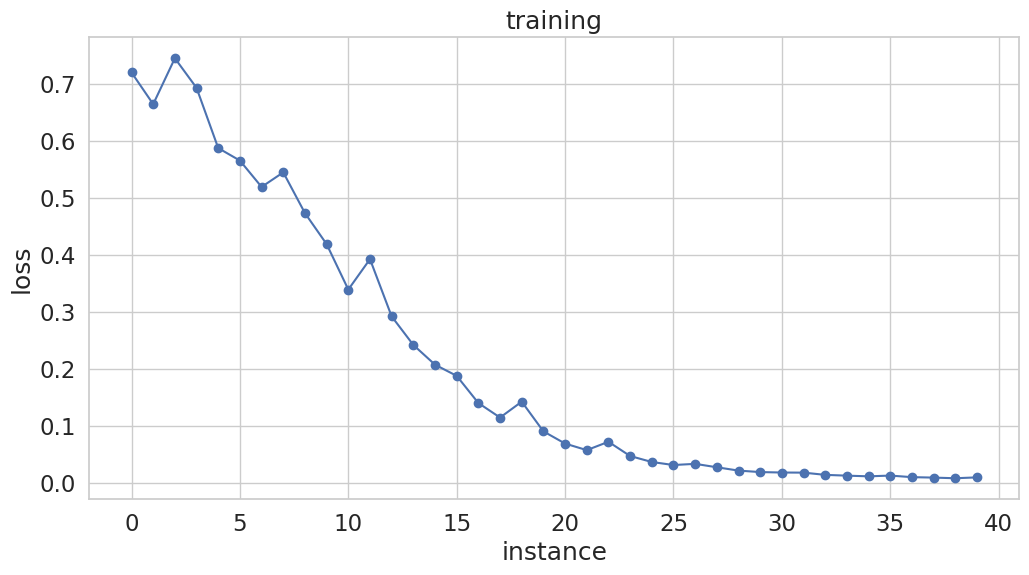

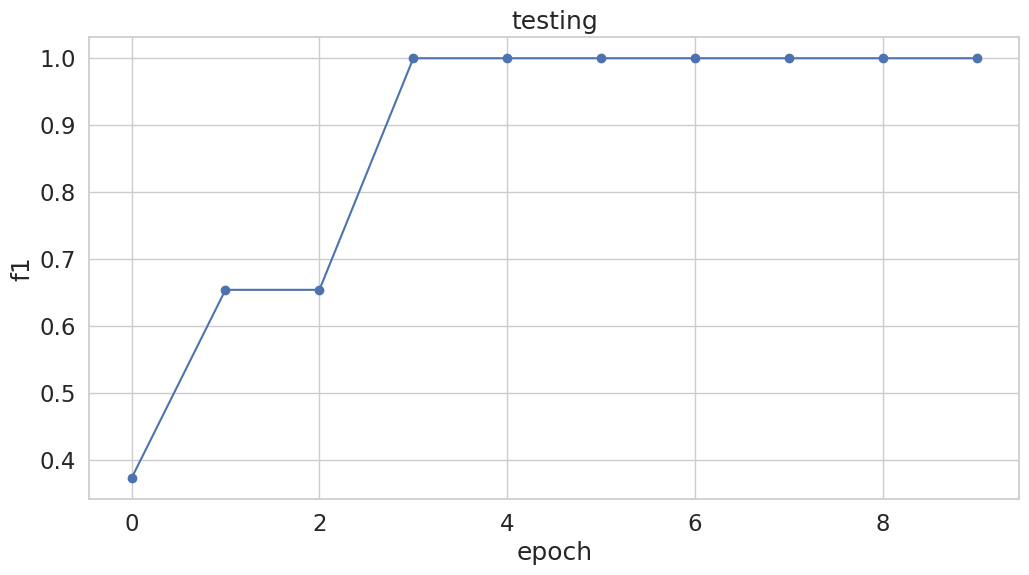

RNN(
  (input_to_hidden): Linear(in_features=7, out_features=2, bias=True)
  (hidden_to_hidden): Linear(in_features=2, out_features=2, bias=True)
  (hidden_to_output): Linear(in_features=2, out_features=3, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [222]:
def train_rnn(rnn, train_data, test_data, epochs=20, learning_rate=0.1, plot=True):
    torch.random.manual_seed(42)  # for reproducibility
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(rnn.parameters(),
                                 lr=learning_rate) 
    rnn.verbose = False
    loss_val = []
    test_acc = []
    # main training loop
    # here, we're updating after each sentence.
    # to improve convergence, we should really use mini-batches (e.g., a group of ~20 sentences)
    # but, this is a bit easier.
    for epoch in tqdm(range(epochs), total=epochs):
        for sentence, tags in train_data:
            optimizer.zero_grad()                             # reset all the gradient information
            outputs, hiddens = rnn.forward_unrolled(sentence) # predict on this sentence
            loss = criterion(outputs, tags)                   # compute loss
            loss.backward()                                   # computes all the gradients
            optimizer.step()                                  # update parameters
            loss_val.append(loss.item())                      # track loss on each sentence
        # after each epoch, record the test accuracy.
        test_acc.append(evaluate_rnn(rnn, test_data, verbose=False))
    if plot:
        # plot training loss
        plt.figure()
        plt.plot(loss_val, 'bo-')
        plt.ylabel('loss')
        plt.xlabel('instance')
        plt.title('training')
        plt.show()
        # plot testing F1
        plt.figure()
        plt.plot(test_acc, 'bo-')
        plt.ylabel('f1')
        plt.xlabel('epoch')
        plt.title('testing')
        plt.show()
    return rnn


def evaluate_rnn(rnn, data, verbose=True):
    rnn.verbose = False
    truths = []
    preds = []
    for sentence, tag_list in data:
        outputs, _ = rnn.forward_unrolled(sentence)
        pred = [output2label(output, rnn.states) for output in outputs]
        truth = [output2label(tag, rnn.states) for tag in tag_list]
        truths.extend(truth)
        preds.extend(pred)
    if verbose:
        print(classification_report(truths, preds, zero_division=0))
    return f1_score(truths, preds, average='weighted')

rnn = RNN(len(vocab_small), 2, len(states_small), states_small)
train_rnn(rnn, rnn_data_small, rnn_data_small, epochs=10)

The RNN seems to have no problem fitting this tiny dataset.

In [190]:
# here's one prediction of the trained RNN
rnn.verbose=True
_, _ = rnn.forward_unrolled(one_hots(vocab_small, ['the', 'boy', 'jumped']))

h_new
 tensor([[0.9846, 0.9784]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.9866, 0.0082, 0.0053]], grad_fn=<SoftmaxBackward0>) 
top output
 D
h_new
 tensor([[ 0.6585, -0.9980]], grad_fn=<TanhBackward0>) 
output
 tensor([[4.6534e-03, 9.9509e-01, 2.5693e-04]], grad_fn=<SoftmaxBackward0>) 
top output
 N
h_new
 tensor([[-0.9099,  0.9711]], grad_fn=<TanhBackward0>) 
output
 tensor([[0.0046, 0.0027, 0.9927]], grad_fn=<SoftmaxBackward0>) 
top output
 V


### RNNs on real data.

Next, we'll try the larger dataset.

In [191]:
# one-hot-encode the larger POS dataset
rnn_data = [(one_hots(vocab, sentence), one_hots(states, tag_list)) 
            for sentence, tag_list in zip(sentences, tags)]
rnn_data_train, rnn_data_test = rnn_data[:-10], rnn_data[-10:]
print('%d training and %d testing sentences' % (len(rnn_data_train), len(rnn_data_test)))

74 training and 10 testing sentences


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


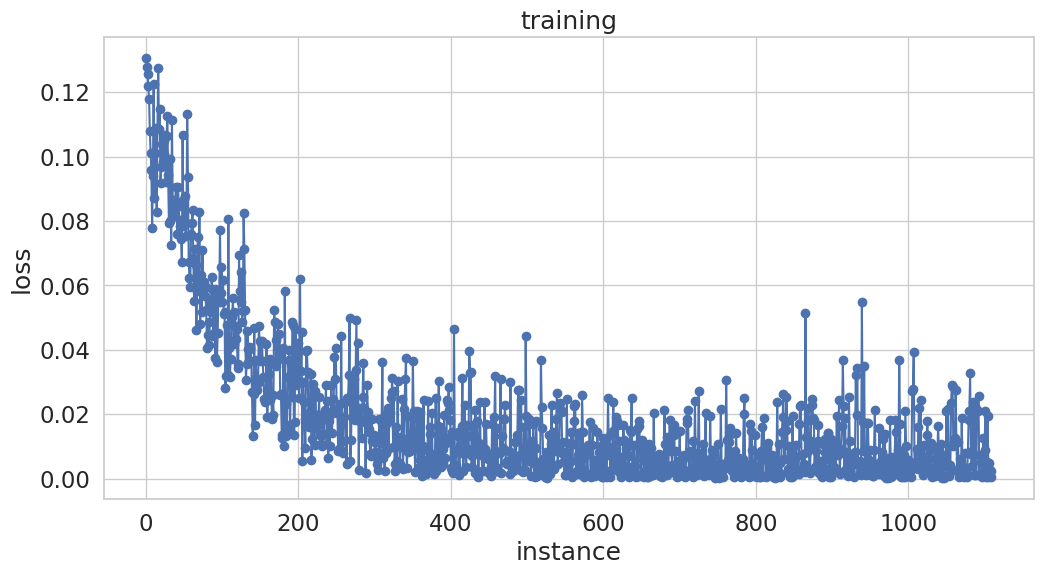

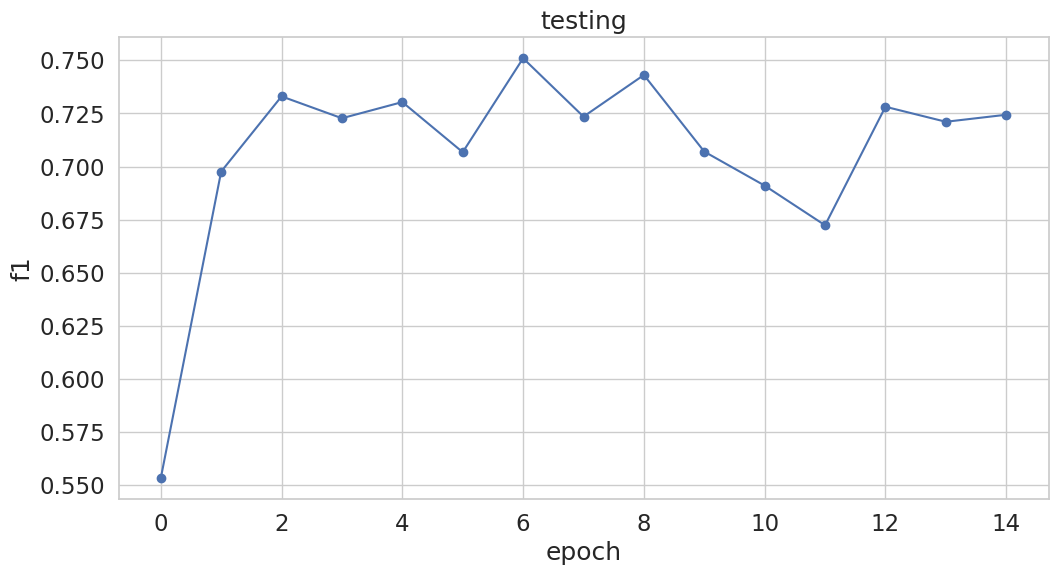

RNN(
  (input_to_hidden): Linear(in_features=716, out_features=5, bias=True)
  (hidden_to_hidden): Linear(in_features=5, out_features=5, bias=True)
  (hidden_to_output): Linear(in_features=5, out_features=34, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [192]:
rnn = RNN(len(vocab), 5, len(states), states)
train_rnn(rnn, rnn_data_train, rnn_data_test, epochs=15)

In [193]:
# predict on one example.
rnn.verbose=True
_, _ = rnn.forward_unrolled(one_hots(vocab, ['Look', 'at', 'what', 'happened']))

h_new
 tensor([[0.2493, 0.9855, 0.9815, 0.9503, 0.5879]], grad_fn=<TanhBackward0>) 
output
 tensor([[2.9938e-06, 2.9878e-02, 2.8681e-07, 2.0324e-09, 1.5784e-02, 6.7664e-10,
         1.0287e-04, 1.4336e-02, 4.5628e-02, 1.2703e-07, 1.7552e-06, 2.5856e-01,
         2.5185e-03, 1.2554e-02, 4.9795e-07, 6.0919e-07, 1.1110e-04, 2.7353e-04,
         2.1855e-04, 1.0586e-03, 4.2534e-06, 2.1035e-05, 7.0698e-04, 1.4078e-10,
         4.2315e-01, 4.4483e-11, 6.1578e-02, 1.1810e-07, 1.6029e-03, 2.5245e-08,
         9.1880e-02, 2.4877e-04, 3.9348e-02, 4.2527e-04]],
       grad_fn=<SoftmaxBackward0>) 
top output
 VB
h_new
 tensor([[ 0.9952, -0.9999, -0.9985,  0.9674, -0.9991]],
       grad_fn=<TanhBackward0>) 
output
 tensor([[4.1379e-11, 1.4131e-08, 4.1079e-10, 2.2119e-11, 1.4564e-07, 2.8917e-07,
         1.8909e-06, 2.1160e-15, 1.8645e-10, 9.9929e-01, 4.6250e-08, 8.7347e-11,
         5.5974e-05, 2.0729e-12, 4.4469e-10, 2.3793e-06, 2.5080e-08, 9.1031e-15,
         3.7157e-08, 4.6370e-11, 4.8185e-06, 3

In [194]:
evaluate_rnn(rnn, rnn_data_test)

              precision    recall  f1-score   support

           $       1.00      1.00      1.00         7
           ,       1.00      1.00      1.00        13
           .       1.00      1.00      1.00        10
          CC       1.00      1.00      1.00         8
          CD       1.00      0.31      0.48        16
          DT       0.59      1.00      0.74        13
          IN       1.00      0.93      0.96        29
          JJ       0.88      0.47      0.61        15
         JJR       0.00      0.00      0.00         3
          NN       0.65      0.72      0.68        36
         NNP       0.59      0.59      0.59        29
        NNPS       0.00      0.00      0.00         1
         NNS       0.81      0.63      0.71        27
         POS       1.00      1.00      1.00         2
          RB       0.00      0.00      0.00         1
         RBR       0.50      1.00      0.67         1
          TO       1.00      1.00      1.00         6
          VB       0.00    

0.7243960812623027

### RNNs with word embeddings

The RNN seems pretty comparable with the HMM. As usual, more data and more tuning would likely lead to higher accuracy for the RNN.

Next, we can use the word embeddings as the input representation for each word, rather than the one-hot encoding.

In [195]:
# Use mean vector if word not in w2v
MEAN_VEC = w2v.vectors.mean(axis=0)

def embed_words_rnn(w2v, sentence):
    """
    Embed each token with its vector from w2v.
    """
    return torch.tensor([w2v[w.lower()] if w.lower() in w2v else MEAN_VEC for w in sentence])
    
rnn_data_embed = [(embed_words_rnn(w2v, sentence), one_hots(states, tag_list)) 
                    for sentence, tag_list in zip(sentences, tags)]
rnn_data_embed_train, rnn_data_embed_test = rnn_data_embed[:-10], rnn_data_embed[-10:]
print('%d training and %d testing sentences' % (len(rnn_data_embed_train), len(rnn_data_embed_test)))

74 training and 10 testing sentences


/tmp/ipykernel_2687/806750809.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor([w2v[w.lower()] if w.lower() in w2v else MEAN_VEC for w in sentence])


In [224]:
# the input dimension has now changed to 50, the size of the word embedding
'''
Test out different combinations of epochs, learning rates, and hidden states to find the best combination, this may take awhile to run.
'''
epochs = [10, 15, 20, 30]
learning_rates = [.02, .01, .005, .0025, .001]
hidden_states = [10, 25, 50, 75, 100]
best = [[],0]
for epoch in epochs:
    for learning_rate in learning_rates:
        for hidden_state in hidden_states:
            rnn = RNN(50, hidden_state, len(states), states)
            rnn.verbose = False
            train_rnn(rnn, rnn_data_embed_train, rnn_data_embed_test, epochs=epoch, learning_rate=learning_rate,plot=False)
            f1 = evaluate_rnn(rnn, rnn_data_embed_test,verbose=False)
            print(f"Epochs: {epoch}, Learning Rate: {learning_rate}, Hidden States: {hidden_state}, F1: {f1}")
            if f1 > best[1]:
                best[0] = [epoch, learning_rate, hidden_state]
                best[1] = f1
print(best)  

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epochs: 10, Learning Rate: 0.02, Hidden States: 10, F1: 0.7484187331676371


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epochs: 10, Learning Rate: 0.02, Hidden States: 25, F1: 0.8030138218280434


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epochs: 10, Learning Rate: 0.02, Hidden States: 50, F1: 0.7743739769730659


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epochs: 10, Learning Rate: 0.02, Hidden States: 75, F1: 0.6692603641362531


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epochs: 10, Learning Rate: 0.02, Hidden States: 100, F1: 0.6333201045311537


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epochs: 10, Learning Rate: 0.01, Hidden States: 10, F1: 0.7339566593179675


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epochs: 10, Learning Rate: 0.01, Hidden States: 25, F1: 0.7768789585010587


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epochs: 10, Learning Rate: 0.01, Hidden States: 50, F1: 0.8059671611871628


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epochs: 10, Learning Rate: 0.01, Hidden States: 75, F1: 0.7784486806366512


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epochs: 10, Learning Rate: 0.01, Hidden States: 100, F1: 0.7632612466930987


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epochs: 10, Learning Rate: 0.005, Hidden States: 10, F1: 0.7276643174579052


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epochs: 10, Learning Rate: 0.005, Hidden States: 25, F1: 0.7822295255029516


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epochs: 10, Learning Rate: 0.005, Hidden States: 50, F1: 0.770829734550257


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epochs: 10, Learning Rate: 0.005, Hidden States: 75, F1: 0.7560410097977251


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epochs: 10, Learning Rate: 0.005, Hidden States: 100, F1: 0.7764358715499214


100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epochs: 10, Learning Rate: 0.0025, Hidden States: 10, F1: 0.6833542125204415


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epochs: 10, Learning Rate: 0.0025, Hidden States: 25, F1: 0.7344738670624205


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epochs: 10, Learning Rate: 0.0025, Hidden States: 50, F1: 0.7760299446653343


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epochs: 10, Learning Rate: 0.0025, Hidden States: 75, F1: 0.7830443508222575


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epochs: 10, Learning Rate: 0.0025, Hidden States: 100, F1: 0.801714309486813


100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epochs: 10, Learning Rate: 0.001, Hidden States: 10, F1: 0.5344100404655976


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epochs: 10, Learning Rate: 0.001, Hidden States: 25, F1: 0.6431132244335341


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epochs: 10, Learning Rate: 0.001, Hidden States: 50, F1: 0.7422108872865562


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epochs: 10, Learning Rate: 0.001, Hidden States: 75, F1: 0.7945952594659492


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epochs: 10, Learning Rate: 0.001, Hidden States: 100, F1: 0.7651896418970586


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


Epochs: 15, Learning Rate: 0.02, Hidden States: 10, F1: 0.7459682740522391


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epochs: 15, Learning Rate: 0.02, Hidden States: 25, F1: 0.8071947149247817


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Epochs: 15, Learning Rate: 0.02, Hidden States: 50, F1: 0.7576101106857788


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


Epochs: 15, Learning Rate: 0.02, Hidden States: 75, F1: 0.7082066568406841


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


Epochs: 15, Learning Rate: 0.02, Hidden States: 100, F1: 0.6800777412239705


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epochs: 15, Learning Rate: 0.01, Hidden States: 10, F1: 0.7321430200190288


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


Epochs: 15, Learning Rate: 0.01, Hidden States: 25, F1: 0.8122774437530396


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Epochs: 15, Learning Rate: 0.01, Hidden States: 50, F1: 0.7764675280332799


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epochs: 15, Learning Rate: 0.01, Hidden States: 75, F1: 0.7898305165738753


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Epochs: 15, Learning Rate: 0.01, Hidden States: 100, F1: 0.6242305638148579


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epochs: 15, Learning Rate: 0.005, Hidden States: 10, F1: 0.7454804786408561


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epochs: 15, Learning Rate: 0.005, Hidden States: 25, F1: 0.7971427715024543


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Epochs: 15, Learning Rate: 0.005, Hidden States: 50, F1: 0.7729006673135117


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


Epochs: 15, Learning Rate: 0.005, Hidden States: 75, F1: 0.7578943019170723


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epochs: 15, Learning Rate: 0.005, Hidden States: 100, F1: 0.7486601725791766


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epochs: 15, Learning Rate: 0.0025, Hidden States: 10, F1: 0.7399220286487898


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


Epochs: 15, Learning Rate: 0.0025, Hidden States: 25, F1: 0.7484517653547869


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


Epochs: 15, Learning Rate: 0.0025, Hidden States: 50, F1: 0.7898173552481008


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Epochs: 15, Learning Rate: 0.0025, Hidden States: 75, F1: 0.7696783195790529


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epochs: 15, Learning Rate: 0.0025, Hidden States: 100, F1: 0.8095918670623657


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Epochs: 15, Learning Rate: 0.001, Hidden States: 10, F1: 0.5834446136233414


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Epochs: 15, Learning Rate: 0.001, Hidden States: 25, F1: 0.69694019384571


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


Epochs: 15, Learning Rate: 0.001, Hidden States: 50, F1: 0.7680781849711379


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Epochs: 15, Learning Rate: 0.001, Hidden States: 75, F1: 0.7931933202969085


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


Epochs: 15, Learning Rate: 0.001, Hidden States: 100, F1: 0.7756554118699541


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epochs: 20, Learning Rate: 0.02, Hidden States: 10, F1: 0.7487380081411308


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epochs: 20, Learning Rate: 0.02, Hidden States: 25, F1: 0.7971480777544573


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Epochs: 20, Learning Rate: 0.02, Hidden States: 50, F1: 0.6910518574992259


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Epochs: 20, Learning Rate: 0.02, Hidden States: 75, F1: 0.6777366710512768


100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Epochs: 20, Learning Rate: 0.02, Hidden States: 100, F1: 0.705613536282155


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epochs: 20, Learning Rate: 0.01, Hidden States: 10, F1: 0.7288998802373549


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epochs: 20, Learning Rate: 0.01, Hidden States: 25, F1: 0.8130361697691195


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Epochs: 20, Learning Rate: 0.01, Hidden States: 50, F1: 0.7872487804917019


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Epochs: 20, Learning Rate: 0.01, Hidden States: 75, F1: 0.7970892615576054


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Epochs: 20, Learning Rate: 0.01, Hidden States: 100, F1: 0.6983260817905967


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Epochs: 20, Learning Rate: 0.005, Hidden States: 10, F1: 0.7645004789508548


100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Epochs: 20, Learning Rate: 0.005, Hidden States: 25, F1: 0.7946701375367801


100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Epochs: 20, Learning Rate: 0.005, Hidden States: 50, F1: 0.7442252178368006


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epochs: 20, Learning Rate: 0.005, Hidden States: 75, F1: 0.7653921147907571


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


Epochs: 20, Learning Rate: 0.005, Hidden States: 100, F1: 0.7829720695404788


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epochs: 20, Learning Rate: 0.0025, Hidden States: 10, F1: 0.7342797500449132


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epochs: 20, Learning Rate: 0.0025, Hidden States: 25, F1: 0.757182097506028


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Epochs: 20, Learning Rate: 0.0025, Hidden States: 50, F1: 0.8002337539711332


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Epochs: 20, Learning Rate: 0.0025, Hidden States: 75, F1: 0.7636102816885014


100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Epochs: 20, Learning Rate: 0.0025, Hidden States: 100, F1: 0.796083291222637


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epochs: 20, Learning Rate: 0.001, Hidden States: 10, F1: 0.6200426401329115


100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epochs: 20, Learning Rate: 0.001, Hidden States: 25, F1: 0.7228237966911608


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epochs: 20, Learning Rate: 0.001, Hidden States: 50, F1: 0.7654350086265849


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


Epochs: 20, Learning Rate: 0.001, Hidden States: 75, F1: 0.8105532600253958


100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Epochs: 20, Learning Rate: 0.001, Hidden States: 100, F1: 0.7492785237892415


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


Epochs: 30, Learning Rate: 0.02, Hidden States: 10, F1: 0.7400202456400096


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


Epochs: 30, Learning Rate: 0.02, Hidden States: 25, F1: 0.7973566664695136


100%|██████████| 30/30 [00:17<00:00,  1.72it/s]


Epochs: 30, Learning Rate: 0.02, Hidden States: 50, F1: 0.7591331259675027


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


Epochs: 30, Learning Rate: 0.02, Hidden States: 75, F1: 0.645377475622391


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


Epochs: 30, Learning Rate: 0.02, Hidden States: 100, F1: 0.6485166581053042


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


Epochs: 30, Learning Rate: 0.01, Hidden States: 10, F1: 0.7353015487893162


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


Epochs: 30, Learning Rate: 0.01, Hidden States: 25, F1: 0.8022641104448844


100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


Epochs: 30, Learning Rate: 0.01, Hidden States: 50, F1: 0.7791511036573238


100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


Epochs: 30, Learning Rate: 0.01, Hidden States: 75, F1: 0.7838456103641105


100%|██████████| 30/30 [00:19<00:00,  1.53it/s]


Epochs: 30, Learning Rate: 0.01, Hidden States: 100, F1: 0.6962319403222307


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


Epochs: 30, Learning Rate: 0.005, Hidden States: 10, F1: 0.7701694068731871


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Epochs: 30, Learning Rate: 0.005, Hidden States: 25, F1: 0.7919860652112998


100%|██████████| 30/30 [00:18<00:00,  1.67it/s]


Epochs: 30, Learning Rate: 0.005, Hidden States: 50, F1: 0.747707433039864


100%|██████████| 30/30 [00:18<00:00,  1.63it/s]


Epochs: 30, Learning Rate: 0.005, Hidden States: 75, F1: 0.7653792347500986


100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


Epochs: 30, Learning Rate: 0.005, Hidden States: 100, F1: 0.774694749961687


100%|██████████| 30/30 [00:16<00:00,  1.78it/s]


Epochs: 30, Learning Rate: 0.0025, Hidden States: 10, F1: 0.7725528800449399


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Epochs: 30, Learning Rate: 0.0025, Hidden States: 25, F1: 0.777401387984843


100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


Epochs: 30, Learning Rate: 0.0025, Hidden States: 50, F1: 0.8040713993419799


100%|██████████| 30/30 [00:18<00:00,  1.58it/s]


Epochs: 30, Learning Rate: 0.0025, Hidden States: 75, F1: 0.7797905946456418


100%|██████████| 30/30 [00:18<00:00,  1.58it/s]


Epochs: 30, Learning Rate: 0.0025, Hidden States: 100, F1: 0.7899637960527639


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


Epochs: 30, Learning Rate: 0.001, Hidden States: 10, F1: 0.6848465684338947


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


Epochs: 30, Learning Rate: 0.001, Hidden States: 25, F1: 0.7730510218405267


100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


Epochs: 30, Learning Rate: 0.001, Hidden States: 50, F1: 0.7785312924247364


100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


Epochs: 30, Learning Rate: 0.001, Hidden States: 75, F1: 0.7826175920922146


100%|██████████| 30/30 [00:19<00:00,  1.53it/s]

Epochs: 30, Learning Rate: 0.001, Hidden States: 100, F1: 0.7318714332159357
[[20, 0.01, 25], 0.8130361697691195]


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


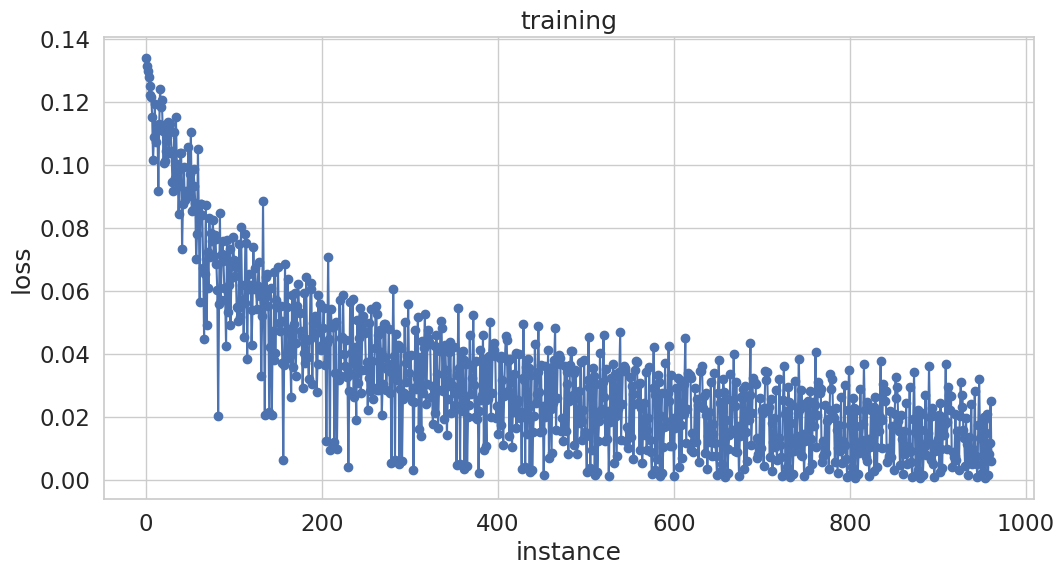

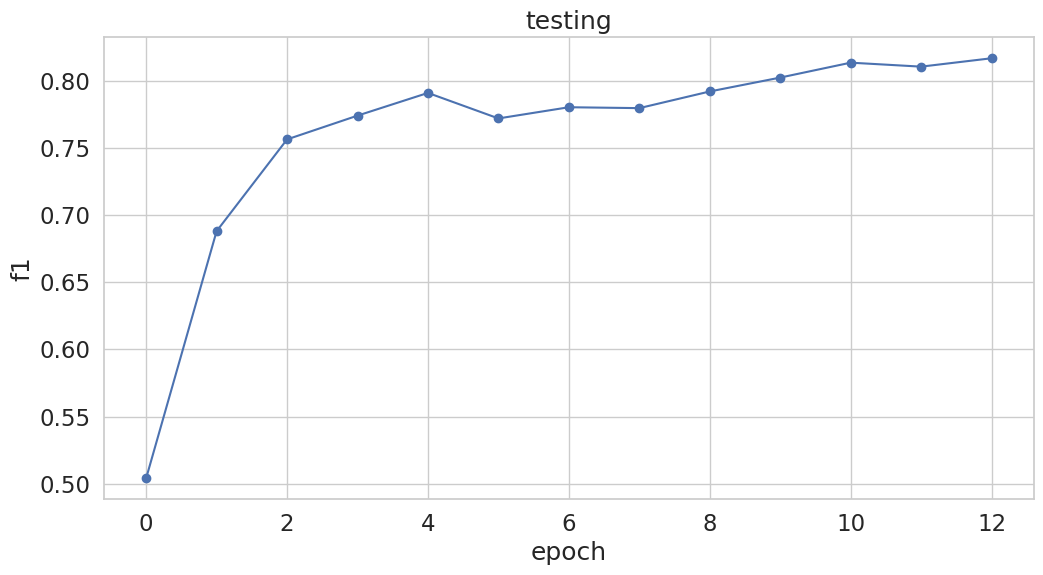

              precision    recall  f1-score   support

           $       1.00      1.00      1.00         7
           ,       1.00      1.00      1.00        13
           .       1.00      1.00      1.00        10
          CC       1.00      1.00      1.00         8
          CD       1.00      0.88      0.93        16
          DT       0.92      0.92      0.92        13
          IN       0.96      0.93      0.95        29
          JJ       0.62      0.67      0.65        15
         JJR       0.00      0.00      0.00         3
          NN       0.61      0.69      0.65        36
         NNP       0.92      0.76      0.83        29
        NNPS       0.50      1.00      0.67         1
         NNS       0.70      0.78      0.74        27
         POS       1.00      1.00      1.00         2
          RB       0.00      0.00      0.00         1
         RBR       0.50      1.00      0.67         1
          TO       1.00      1.00      1.00         6
          VB       1.00    

0.8166936874233055

In [226]:
#best results from above in more detail, when looking at the graph testing error is maxed at epoch 13
rnn = RNN(50, 20, len(states), states)
train_rnn(rnn, rnn_data_embed_train, rnn_data_embed_test, epochs=13, learning_rate=.01)
evaluate_rnn(rnn, rnn_data_embed_test)

Hmm...at first glance it doesn't seem worth using an RNN with this data. But, maybe we haven't tuned it properly?

Play around with the learning rate, hidden_size, and number of epochs for the final RNN model above. What is the best "weighted avg" F1 you can obtain? What are the values of the tuning parameters you use? One tip -- as you increase hidden size, you may need to reduce the learning rate. 

The best weighted F1 I could get was ~.817 which is pretty solid improvement. The parameters I used were: 

hidden size: 20

epochs: 13

learning rate: .01